In [1]:
from voc_data_loader import image_loader, voc_meta
%matplotlib inline

from models import rpn, resnet, rpn_utils, training_params

import matplotlib
import numpy
import matplotlib.pyplot as plt

In [6]:
loader = image_loader("/home/cadams/DLPlayground/model_voc07_test/VOC2007")
meta = voc_meta("/home/cadams/DLPlayground/model_voc07_test/VOC2007")

In [7]:
batch_size = 1
data, labels, boxes = loader.get_next_val_batch(batch_size, mode="class")

This is the data image shape

In [8]:
print data.shape

(1, 512, 512, 3)


Here is what the bounding boxes look like

In [9]:
print boxes

[[[   8.  174.  298.  395.]
  [ 199.  271.  443.  396.]
  [ 400.  397.  425.  437.]
  [ 387.  394.  401.  424.]
  [ 351.  383.  365.  427.]
  [ 483.  394.  507.  445.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]
  [   0.    0.    0.    0.]]]


And lastly, here are the labels (one-hot format):

In [10]:
print labels

[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
   0.  0.]]


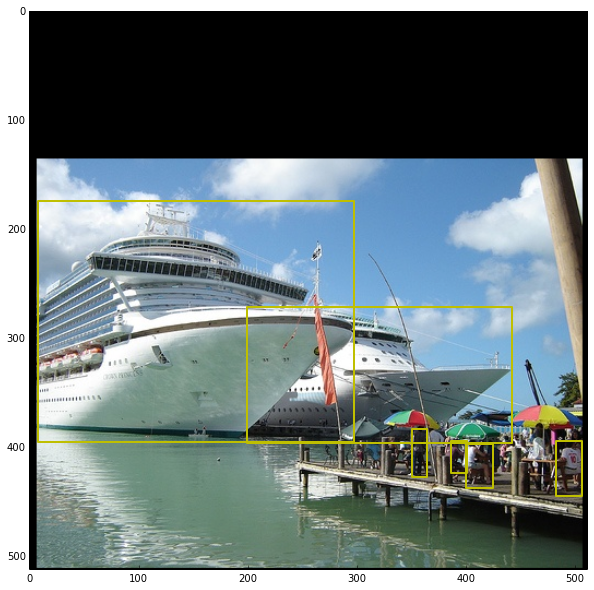

In [11]:
for i in range(batch_size):
    fig,ax = plt.subplots(figsize=(10,10))
    plt.imshow(data[i])
    for j_roi in range(len(boxes[i])):
        box = boxes[i][j_roi]
        rect = matplotlib.patches.Rectangle((box[0],box[1]),
                                            box[2] - box[0],
                                            box[3] - box[1],
                                            linewidth=2,
                                            edgecolor='y',
                                            facecolor='none')
#         ax.text(box[0], box[1],class_name, fontsize=15)
        ax.add_patch(rect)
    plt.show()


Now set up the tensorflow interface to do forward pass prediction

In [12]:
import tensorflow as tf
import numpy


Define parameters for the convolutional network and the RPN:

In [13]:

# Use a resnet for the convolutional step:
conv_params = resnet.resnet_params()
conv_params.network_params()['n_blocks'] = 8
conv_params.network_params()['include_final_classifier'] = False
conv_params.network_params()['n_classes'] = 20
conv_params.network_params()['n_initial_filters'] = 12
conv_params.network_params()['downsample_interval'] = 2
conv_params.network_params()['initial_stride'] = 2
conv_params.network_params()['initial_kernel'] = 5
conv_params.network_params()['bottleneck'] = False
conv_params.network_params()['weight_decay'] = 1E-3
conv_params.network_params()['activation'] = 'softmax'


# Set up the network we want to test:
rpn_params = rpn.rpn_params()
rpn_params.network_params()['n_anchors_per_box'] = 9
rpn_params.network_params()['weight_decay'] = 1E-3
rpn_params.network_params()['n_selected_regressors'] = 56

LOGDIR="logs/rpn_resnet/resnet_ik_5_nb_8_di_2_is_2_B_False_nf_12/"

Next, set up the trained network:

In [14]:
# Set up the graph:

tf.reset_default_graph()

N_MAX_TRUTH = 10
# Set input data and label for training
data_tensor = tf.placeholder(tf.float32, [None, 512,512,3], name='x')
label_tensor = tf.placeholder(tf.float32, [None, 20], name='labels')
box_label = tf.placeholder(tf.float32, [N_MAX_TRUTH, 4], name='truth_anchors')

# Let the convolutional part of the network be independant
# of the classifiers:
with tf.variable_scope("ResNet"):

    conv_net = resnet.resnet(conv_params)
    final_conv_layer = conv_net.build_network(input_tensor=data_tensor,
                                              is_training=False)    


names = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="ResNet")
n = final_conv_layer.get_shape().as_list()[1]

with tf.variable_scope("Classification-FC"):
    x = tf.layers.conv2d(final_conv_layer,
                         512,
                         kernel_size=[n, n],
                         strides=[1, 1],
                         padding='valid',
                         activation=None,
                         use_bias=False,
                         kernel_initializer=None,  # automatically uses Xavier initializer
                         kernel_regularizer=None,
                         activity_regularizer=None,
                         trainable=True,
                         name="Conv2DNxN",
                         reuse=None)


with tf.variable_scope("Classification-Final"):
    classifier = tf.layers.conv2d(x,
                                 20,
                                 kernel_size=[1, 1],
                                 strides=[1, 1],
                                 padding='same',
                                 activation=None,
                                 use_bias=False,
                                 kernel_initializer=None,  # automatically uses Xavier initializer
                                 kernel_regularizer=None,
                                 activity_regularizer=None,
                                 trainable=True,
                                 name="Conv2D1x1",
                                 reuse=None)

    # Reshape the classifier into the feature map pools it was using:
    classifier = tf.reshape(classifier, (tf.shape(classifier)[0], 20))

prediction = tf.sigmoid(classifier)





In [15]:
other_names = []
for n in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES):
    if n not in names:
        other_names.append(n)
print other_names

# print names


[<tf.Variable 'Classification-FC/Conv2DNxN/kernel:0' shape=(32, 32, 96, 512) dtype=float32_ref>, <tf.Variable 'Classification-Final/Conv2D1x1/kernel:0' shape=(1, 1, 512, 20) dtype=float32_ref>]


In [16]:
correct_prediction = tf.equal(tf.argmax(classifier, axis=-1),tf.argmax(label_tensor, axis=-1))

Restore the network:

In [17]:
sess = tf.InteractiveSession()        
# checkpoint_file = LOGDIR + '/checkpoints/' + "save-50"
latest_checkpoint = tf.train.latest_checkpoint(LOGDIR+"/checkpoints/")
# print latest_checkpoint
all_saver = tf.train.Saver()
all_saver.restore(sess, latest_checkpoint)

INFO:tensorflow:Restoring parameters from logs/rpn_resnet/resnet_ik_5_nb_8_di_2_is_2_B_False_nf_12//checkpoints/save-7000


Run a forward pass of the network:

In [31]:
data, labels, boxes = loader.get_next_train_batch(1, mode='class')
# labels = numpy.squeeze(labels)
# boxes = numpy.squeeze(boxes)
cls, pred = sess.run(
                [classifier, prediction], 
                feed_dict={data_tensor : data,
                           label_tensor: labels
                           # regressor : _fake_regressor, 
#                            anchors : _anchors
                          })


print labels
print (pred > 0.95).astype(float)

# Absolute accuracy is just the rounded prediction:
acc = numpy.mean(labels == numpy.round(pred))

#thresholded accuracy is the thresholded prediction:
threshold = 0.95
thres_pred = pred > threshold
thres_acc = numpy.mean(labels == thres_pred)
print "Full accuracy: {}".format(acc)
print "Thresholded ({}) Accuracy: {}".format(threshold, thres_acc)

[[ 0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.]]
[[ 0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.]]
Full accuracy: 0.95
Thresholded (0.95) Accuracy: 1.0


In [40]:
pos_indexes = numpy.where(cls[:,1] > 0.99999)[0]
pos_boxes = rgs[pos_indexes]
pos_anchors = _anchors[pos_indexes]
print pos_indexes
print pos_anchors
print pos_boxes

NameError: name 'rgs' is not defined

In [ ]:
print data.shape

Draw the output of this forward pass:

In [ ]:
n_roi_true = int(numpy.sum(labels))
fig,ax = plt.subplots(figsize=(15,15))
plt.imshow(data)
for box, label in zip(boxes, labels):
    class_name = meta.class_name(numpy.argmax(label))
    rect = matplotlib.patches.Rectangle((box[0],box[1]),
                                        box[2] - box[0],
                                        box[3] - box[1],
                                        linewidth=2,
                                        edgecolor='y',
                                        facecolor='none')
    ax.text(box[0], box[1],class_name, fontsize=15)
    ax.add_patch(rect)

#Convert the boxes to xyctrs format:
pos_boxes = rpn_utils.boxes_regcoord_to_whctrs(pos_boxes, pos_anchors)
print pos_boxes
pos_boxes = rpn_utils.boxes_whctrs_to_minmax(pos_boxes)
print pos_boxes
# pos_boxes = rpn_utils.
# for box in pos_boxes:
#     rect = matplotlib.patches.Rectangle((box[0],box[1]),
#                                         box[2] - box[0],
#                                         box[3] - box[1],
#                                         linewidth=2,
#                                         edgecolor='r',
#                                         facecolor='none')
#     ax.text(box[0], box[1],class_name, fontsize=15)
#     ax.add_patch(rect)
# Draw the boxes on the image

# print cls[pos_indexes]

# Draw some boxes
    
plt.show()